# 6장. 물류 최적화
앞서 4-5장에서는 **실전 편 - 머신러닝** 에 대해 공부했다.  
(그래서 데이터를 가공 , 사전 분석(EDA), 머신러닝을 활용한 예측까지를 다루면서 여러 인사이트를 발견하였다.)  
이번 6-8장에서는 **실전 편 - 최적화**에 대해 공부해볼 것이다.  여기서 다루는 데이터는 물류 데이터로 이전 파트보다는 좀 더 복잡하다.  
물류의 최적 경로를 발견하는 **최적 경로 탐색**, 회사의 비즈니스를 개선하는 **최적 리소스 분배** , **시뮬레이션(미래 예측)** 등의 내용을 다뤄볼 것이다.  

---
머신러닝도 그렇지만, 최적화의 경우에도 잘 활용될 수 있는 분야가 있고 아닌 분야가 있다. 앞서 머신러닝에선 고객의 이용횟수나 이탈을 예측하는 등 B2C 회사의 경우 잘 맞다. (커머스 업계, 게임 업계 등)  
최적화는 시간이나 경로를 계산하는 분야에 잘 맞는다. 이를테면 지하철 시간표를 짜는 것, 물류창고의 최적 경로 탐색, 모빌리티 업계에서의 차량/자전거 재배치 등이다. 인사 관리를 할 때 아르바이트 타임 스케쥴을 짤 때에도 최적화를 적용할 수 있다. 여기서는 *물류창고의 최적 경로 탐색* 최적화를 해보자!

- 이번 6장에서는 '물류'의 기초가 되는 '운송최적화'를 검토하고 기초적인 기술을 배운다.  
    - 네트워크 구조 가시화
    - 최적 물류 계획 세우기
- 이를 바탕으로 물류비용을 줄이고 더 효율적인 운송이 가능하도록 만들어보자.  

---
사용하는 데이터(2019.01.01 - 2019.12.31)
- tbl_factory.csv : 공장 데이터
- tbl_warehouse.csv : 창고 데이터
- rel_cost.csv : 창고 - 공장 간 운송비용
- tbl_transaction.csv : 2019년 공장으로의 부품 운송 실적

## Tech 51. 물류 데이터를 불러오자

In [1]:
import pandas as pd

fac = pd.read_csv('6장/tbl_factory.csv', index_col = 0)
w = pd.read_csv('6장/tbl_warehouse.csv', index_col = 0)
cost = pd.read_csv('6장/rel_cost.csv', index_col = 0)
trans = pd.read_csv('6장/tbl_transaction.csv', index_col = 0)

print(fac.shape, w.shape, cost.shape, trans.shape)
display(fac.head(), w.head(), cost.head(), trans.head())

(8, 3) (6, 3) (24, 3) (4000, 4)


,FCName,FCDemand,FCRegion
FCID,,,
FC00001,서울공장,28,북부
FC00002,수원공장,29,북부
FC00003,인천공장,31,북부
FC00004,대전공장,25,북부
FC00005,대구공장,21,남부


,WHName,WHSupply,WHRegion
WHID,,,
WH00001,판교창고,35,북부
WH00002,용인창고,41,북부
WH00003,수원창고,42,북부
WH00004,대전창고,60,남부
WH00005,대구창고,72,남부


,FCID,WHID,Cost
RCostID,,,
1,FC00001,WH00001,0.4
2,FC00001,WH00002,0.8
3,FC00001,WH00003,1.5
4,FC00002,WH00001,0.9
5,FC00002,WH00002,0.8


,TransactionDate,ToFC,FromWH,Quantity
TRID,,,,
0,2019-01-01 02:11:10,FC00004,WH00003,33
1,2019-01-01 06:12:42,FC00007,WH00006,19
2,2019-01-01 06:32:32,FC00006,WH00004,31
3,2019-01-01 07:17:06,FC00002,WH00003,18
4,2019-01-01 07:52:18,FC00001,WH00002,30


- 데이터를 보면, 모든 4개의 데이터에 공통으로 존재하는 것은 '공장 정보'와 '창고 정보'임을 알 수 있다.
    - 그래서 이 2개 컬럼을 key로 하여 데이터를 조인한다. (단, fac, w, cost에서 얘네의 컬럼명은 FCID, WHID이지만 trans에서만 ToFC, FromWH로 되어 있으니 주의. 컬럼명만 다를 뿐 동일한 값이다
- 가장 중요한 테이블은 운송 실적(trans) 이므로 얘를 중심으로 각 정보를 결합 -> left join

In [2]:
#먼저, trans에 cost 조인
join_data = pd.merge(trans, cost, left_on = ['ToFC', 'FromWH'],  right_on = ['FCID', 'WHID'], how= 'left')
join_data

,TransactionDate,ToFC,FromWH,Quantity,FCID,WHID,Cost
0,2019-01-01 02:11:10,FC00004,WH00003,33,FC00004,WH00003,1.1
1,2019-01-01 06:12:42,FC00007,WH00006,19,FC00007,WH00006,1.3
2,2019-01-01 06:32:32,FC00006,WH00004,31,FC00006,WH00004,0.9
3,2019-01-01 07:17:06,FC00002,WH00003,18,FC00002,WH00003,1.6
4,2019-01-01 07:52:18,FC00001,WH00002,30,FC00001,WH00002,0.8
...,...,...,...,...,...,...,...
3995,2019-12-31 11:27:51,FC00007,WH00006,29,FC00007,WH00006,1.3
3996,2019-12-31 17:10:21,FC00002,WH00003,35,FC00002,WH00003,1.6
3997,2019-12-31 19:35:07,FC00003,WH00001,36,FC00003,WH00001,1.2
3998,2019-12-31 21:45:07,FC00005,WH00005,34,FC00005,WH00005,0.3


In [3]:
#그다음은 공장정보(fac) 조인
join_data =  pd.merge(join_data, fac , on = 'FCID', how='left')
join_data

,TransactionDate,ToFC,FromWH,Quantity,FCID,WHID,Cost,FCName,FCDemand,FCRegion
0,2019-01-01 02:11:10,FC00004,WH00003,33,FC00004,WH00003,1.1,대전공장,25,북부
1,2019-01-01 06:12:42,FC00007,WH00006,19,FC00007,WH00006,1.3,부산공장,25,남부
2,2019-01-01 06:32:32,FC00006,WH00004,31,FC00006,WH00004,0.9,광주공장,30,남부
3,2019-01-01 07:17:06,FC00002,WH00003,18,FC00002,WH00003,1.6,수원공장,29,북부
4,2019-01-01 07:52:18,FC00001,WH00002,30,FC00001,WH00002,0.8,서울공장,28,북부
...,...,...,...,...,...,...,...,...,...,...
3995,2019-12-31 11:27:51,FC00007,WH00006,29,FC00007,WH00006,1.3,부산공장,25,남부
3996,2019-12-31 17:10:21,FC00002,WH00003,35,FC00002,WH00003,1.6,수원공장,29,북부
3997,2019-12-31 19:35:07,FC00003,WH00001,36,FC00003,WH00001,1.2,인천공장,31,북부
3998,2019-12-31 21:45:07,FC00005,WH00005,34,FC00005,WH00005,0.3,대구공장,21,남부


In [4]:
#그다음은 창고정보(w) 조인
join_data = pd.merge(join_data, w, on = 'WHID', how='left')
join_data

,TransactionDate,ToFC,FromWH,Quantity,FCID,WHID,Cost,FCName,FCDemand,FCRegion,WHName,WHSupply,WHRegion
0,2019-01-01 02:11:10,FC00004,WH00003,33,FC00004,WH00003,1.1,대전공장,25,북부,수원창고,42,북부
1,2019-01-01 06:12:42,FC00007,WH00006,19,FC00007,WH00006,1.3,부산공장,25,남부,광주창고,65,남부
2,2019-01-01 06:32:32,FC00006,WH00004,31,FC00006,WH00004,0.9,광주공장,30,남부,대전창고,60,남부
3,2019-01-01 07:17:06,FC00002,WH00003,18,FC00002,WH00003,1.6,수원공장,29,북부,수원창고,42,북부
4,2019-01-01 07:52:18,FC00001,WH00002,30,FC00001,WH00002,0.8,서울공장,28,북부,용인창고,41,북부
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,2019-12-31 11:27:51,FC00007,WH00006,29,FC00007,WH00006,1.3,부산공장,25,남부,광주창고,65,남부
3996,2019-12-31 17:10:21,FC00002,WH00003,35,FC00002,WH00003,1.6,수원공장,29,북부,수원창고,42,북부
3997,2019-12-31 19:35:07,FC00003,WH00001,36,FC00003,WH00001,1.2,인천공장,31,북부,판교창고,35,북부
3998,2019-12-31 21:45:07,FC00005,WH00005,34,FC00005,WH00005,0.3,대구공장,21,남부,대구창고,72,남부


In [5]:
#이제 직관적으로 보기 쉽게 컬럼 순서 지정
join_data = join_data[['TransactionDate', 'Quantity', 'Cost', 'ToFC', 'FCName', 'FCDemand', 'FromWH', 'WHName', 'WHSupply', 'WHRegion']]
join_data.head()

,TransactionDate,Quantity,Cost,ToFC,FCName,FCDemand,FromWH,WHName,WHSupply,WHRegion
0,2019-01-01 02:11:10,33,1.1,FC00004,대전공장,25,WH00003,수원창고,42,북부
1,2019-01-01 06:12:42,19,1.3,FC00007,부산공장,25,WH00006,광주창고,65,남부
2,2019-01-01 06:32:32,31,0.9,FC00006,광주공장,30,WH00004,대전창고,60,남부
3,2019-01-01 07:17:06,18,1.6,FC00002,수원공장,29,WH00003,수원창고,42,북부
4,2019-01-01 07:52:18,30,0.8,FC00001,서울공장,28,WH00002,용인창고,41,북부


In [6]:
#이제 Region이 북부/남부인 것으로만 나누어 저장
north = join_data.loc[join_data['WHRegion'] == '북부']
south = join_data.loc[join_data['WHRegion'] == '남부']
print(len(north), len(south))

2000 2000


## Tech 52. 현재 운송량과 비용을 확인하자
이제 데이터가 잘 불러와졌다. 실제 운송량과 비용을 확인하고 지사 간 비교를 해보자.

In [48]:
#지사 간 비용 확인 -> 북부지사 > 남부지사 
print("북부지사 총비용: " + str(north['Cost'].sum()) + "만원")
print("남부지사 총비용: " + str(south['Cost'].sum()) + "만원")

#지사 간 운송량 확인 -> 북부지사 < 남부지사 
print("북부지사 총부품 운송개수: " + str(north['Quantity'].sum()) + "개")
print("남부지사 총부품 운송개수: " + str(south['Quantity'].sum()) + "개")

북부지사 총비용: 2189.3만원
남부지사 총비용: 2062.0만원
북부지사 총부품 운송개수: 49146개
남부지사 총부품 운송개수: 50214개


In [49]:
#지사 간 1개당 운송비용은? -> 위 결과에서도 보았듯 북부 > 남부 . 남부가 좀 더 효율적으로 비용을 쓰는 듯 
tmp = (north['Cost'].sum()/ north['Quantity'].sum()) *10000
tmp2 = (south['Cost'].sum()/ south['Quantity'].sum()) *10000
print('북부지사 부품 1개당 운송비용: ' +str(int(tmp)) + '원') #소수점으로 나오는 것 방지를 위해 int로 바꿔줌 
print('남부지사 부품 1개당 운송비용: ' +str(int(tmp2)) + '원')

북부지사 부품 1개당 운송비용: 445원
남부지사 부품 1개당 운송비용: 410원


운송비용은 창고-> 공장 간에 발생하기 때문에, **단순히 운송비용 절감을 하는 것만으로도 전체 물류 비용을 억제**할 수 있다.  

In [10]:
#지사 간 평균 운송비용 확인
cost_chk = pd.merge(cost, fac, on = 'FCID', how= 'left') #앞서 만든 north, south는 운영실적이 있는 데이터에 대해서만 걸러졌으므로 비용 데이터를 다시 만든다.
cost_chk.head()

,FCID,WHID,Cost,FCName,FCDemand,FCRegion
0,FC00001,WH00001,0.4,서울공장,28,북부
1,FC00001,WH00002,0.8,서울공장,28,북부
2,FC00001,WH00003,1.5,서울공장,28,북부
3,FC00002,WH00001,0.9,수원공장,29,북부
4,FC00002,WH00002,0.8,수원공장,29,북부


In [11]:
#북부/ 남부별로 평균비용값 확인
print('북부 평균비용: ', cost_chk.loc[(cost_chk['FCRegion'] == '북부')]['Cost'].mean())
print('남부 평균비용: ', cost_chk.loc[(cost_chk['FCRegion'] == '남부')]['Cost'].mean())

북부 평균비용:  1.075
남부 평균비용:  1.05


둘의 평균비용은 거의 같다. 드는 비용은 동일한데,  
앞서 운영실적으로 살펴봤을 때는 북부가 운영비용을 많이 쓰는데 운송한 수는 더 적었으므로 *남부*가 더 효율적인 운송을 하고 있음을 알 수있다.  
이제 숫자뿐 아니라 실제로 시각화를 통해서 물류 최적 경로를 분석하고 컨설팅해보자.

## Tech 53. 네트워크 가시화하기 (기초)
최적화 라이브러리는 다양한 게 있지만 여기서는 `NetworkX` 를 써본다.

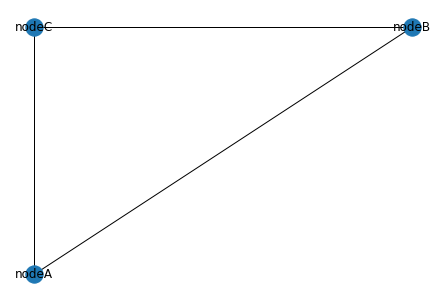

In [12]:
import networkx as nx
import matplotlib.pyplot as plt

#그래프 객체 설정
G = nx.Graph()

#노드 설정
G.add_node('nodeA')
G.add_node('nodeB')
G.add_node('nodeC')

#엣지 설정
G.add_edge('nodeA', 'nodeB')
G.add_edge('nodeA', 'nodeC')
G.add_edge('nodeB', 'nodeC')

#좌표 설정
pos = {}
pos['nodeA'] = (0,0)
pos['nodeB'] = (1,1)
pos['nodeC'] = (0,1)

#그리기
nx.draw(G, pos, with_labels= True)
plt.show()

In [13]:
pos

{'nodeA': (0, 0), 'nodeB': (1, 1), 'nodeC': (0, 1)}

## Tech 54. 네트워크에 노드를 추가(기초)

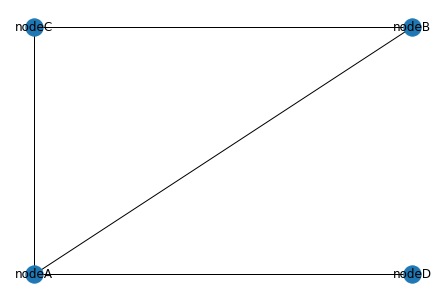

In [14]:
#앞서 만든 그림에 새로운 노드 nodeD(nodeA와 연결되는)를 추가한다.

#노드
G.add_node('nodeD')
#엣지
G.add_edge('nodeA', 'nodeD')
#좌표설정
pos['nodeD'] = (1,0)

#그리기
nx.draw(G, pos, with_labels = True)

## Tech 55. 경로에 가중치 부여하기(기초)
여기까지가 기본적인 경로를 그려봤다면, 그 경로를 더 많이 사용할수록 가중치를 부여해야 한다.  
가중치를 더 많이 부여할수록 노드 사이의 '엣지'의 굵기를 더 굵게 하면 된다.  
가중치를 얻어오는 방법은 여러가지이지만 여기서는 csv 파일에 저장된 가중치 정보를 데이터프레임으로 읽어들여 사용한다.

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

#데이터 불러오기
df_w = pd.read_csv('6장/network_weight.csv') #가중치
df_p = pd.read_csv('6장/network_pos.csv') #좌표

display(df_w, df_p)

,A,B,C,D,E
0,0.639921,0.143353,0.944669,0.521848,0.000000
1,0.264556,0.000000,0.456150,0.568434,0.000000
2,0.617635,0.612096,0.616934,0.943748,0.000000
3,0.000000,0.000000,0.697631,0.060225,0.666767
4,0.670638,0.210383,0.000000,0.315428,0.000000


,A,B,C,D,E
0,0,0,2,2,1
1,0,2,0,2,1


교재에서 주어진 예제 데이터에는 A에서 E까지 5개 노드가 있고, df_w에는 각 노드 간(엣지)의 가중치, df_p에는 노드 좌표가 들어있다.

In [16]:
#엣지 가중치 리스트화-> 각 행, 열에 해당하는 가중치를 df_w에서 뽑아서 넣기(너무 값이 작으므로 10 곱함)
size = 10
edge_w = []

for i in range(len(df_w)):
    for j in range(len(df_w.columns)):
        edge_w.append(df_w.iloc[i][j]*size)
        
edge_w

[6.39921,
 1.4335300000000002,
 9.44669,
 5.21848,
 0.0,
 2.64556,
 0.0,
 4.5615,
 5.68434,
 0.0,
 6.17635,
 6.12096,
 6.16934,
 9.43748,
 0.0,
 0.0,
 0.0,
 6.97631,
 0.60225,
 6.66767,
 6.706379999999999,
 2.10383,
 0.0,
 3.15428,
 0.0]

In [17]:
df_p

,A,B,C,D,E
0,0,0,2,2,1
1,0,2,0,2,1


In [18]:
df_p.loc[1, 'A']

0

In [19]:
df_p['B'][1]

2

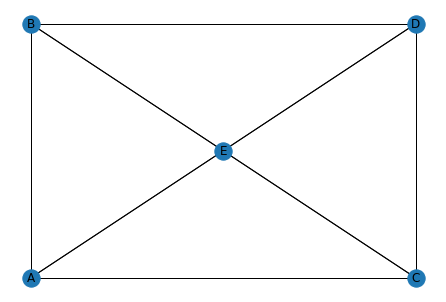

In [20]:
#객체
G = nx.Graph()

#노드 5개 설정 
for i in range(len(df_w.columns)):
    G.add_node(df_w.columns[i])
    
#엣지 설정(노드 5개중 2개씩 뽑아 연결-자기자신과 연결하거나 중복되어도 됨!)
for i in range(len(df_w.columns)):
    for j in range(len(df_w.columns)):
        G.add_edge(df_w.columns[i], df_w.columns[j])
        
#좌표 설정
pos = {}
for i in range(len(df_w.columns)):
    node = df_w.columns[i]
    a1 = df_p.loc[0, node]
    a2 = df_p.loc[1, node]
    pos[node] = (a1, a2)  #pos[노드] = (좌표) 임을 이용 
    #또는 다음 코드도 동일 
    #pos[node] = (df_p[node][0], df_p[node][1]) 
    
#그리기
nx.draw(G, pos, with_labels=True)
  #             font_size = 16, node_size = 1000, node_color= 'k', font_color = 'w', width = edge_w) #가중치는 width 옵션으로 지정 
plt.show()

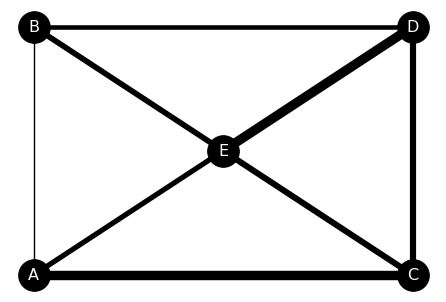

In [21]:
#엣지에 가중치 추가, 꾸미기
nx.draw(G, pos, with_labels=True,
              font_size = 16, node_size = 1000, node_color= 'k', font_color = 'w', width = edge_w) #가중치는 width 옵션으로 지정 
plt.show()

## Tech 56. 운송 경로 정보를 불러오자.
위에서 쓴 기본적인 네트워크 코드를 사용해 직접 우리의 물류 데이터를 가시화해보자.  
네트워크를 가시화하면 숫자만으로는 알기 어려운 물류의 쏠림과 같은 전체 그림을 파악할 수 있다.  
먼저 운송경로 데이터가 없으므로 이를 불러오고 tech 57번에서 가시화한다.  

---
- trans_route.csv : 운송경로
- trans_route_pos.csv : 창고 및 공장 위치정보
- trans_cost.csv : 창고-공장 간 운송비용
- demand.csv : 공장 제품 생산량 수요
- supply.csv : 창고가 공급할수 있는 최대 부품 수
- trans_route_new.csv : 새로 설계한 운송경로

In [22]:
#어떤 제품의 부품에 대해, 창고 W1, W2, W3 에서 -> 공장 F1, F2, F3, F4로 필요한 양의 부품을 운송한다.
#우리는 최소의 비용으로 운송을 하고 싶으므로, 어떤 창고에서 어떤 공장으로 어느 정도 양을 운송해야 하는지 그 최적값을 찾아야 함.

#이전에 어떤 창고에서 어떤 공장으로 어느 정도 양을 운송했는지를 담은 데이터(운송경로) 를 불러옴
df_tr = pd.read_csv('6장/trans_route.csv', index_col = '공장')
df_tr

,F1,F2,F3,F4
공장,,,,
W1,15,15,0,5
W2,5,0,30,5
W3,10,15,2,15


In [23]:
df_pos = pd.read_csv('6장/trans_route_pos.csv')
df_pos

,W1,W2,W3,F1,F2,F3,F4
0,0,0,0,4.0,4.0,4.0,4.0
1,1,2,3,0.5,1.5,2.5,3.5


## Tech 57. 운송경로 정보로 네트워크 가시화하기
위의 `df_tr` 데이터를 네트워크화해보자.

In [24]:
#가중치로 사용
df_tr = pd.read_csv('6장/trans_route.csv', index_col = '공장')
#좌표로 사용
df_pos = pd.read_csv('6장/trans_route_pos.csv')

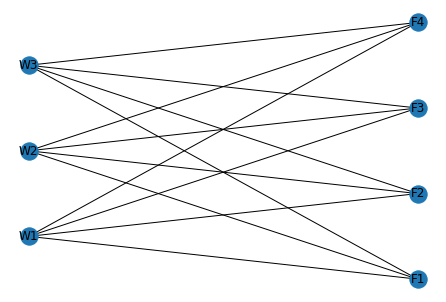

In [25]:
#객체
G = nx.Graph()

#노드 설정(W 3개, F 4개)
for i in range(len(df_pos.columns)):
    G.add_node(df_pos.columns[i])
    
#엣지 설정(W에서 하나 - F에서 하나를 연결)
for i in range(0, 3):
    for j in range(3, len(df_pos.columns)):
        G.add_edge(df_pos.columns[i], df_pos.columns[j])
        
#좌표 설정
pos = {}
for i in range(len(df_pos.columns)):
    node = df_pos.columns[i]
    pos[node] = (df_pos[node][0],df_pos[node][1])
    
#그리기
nx.draw(G, pos, with_labels=True)
plt.show()

In [26]:
#그런데 위에처럼 하면 가중치가 엣지에 제대로 안 들어가므로, 가중치 리스트를 만들어 그래프를 더 꾸며주자!

sy = []
size = 0.1 #가중치 값이 너무 커서 줄임 (그대로 쓰면 엣지가 엄청 굵게나옴)
for i in range(len(df_tr.index)):
    for j in range(len(df_tr.columns)):
        sy.append(df_tr.iloc[i,j]*size)
        
sy

[1.5, 1.5, 0.0, 0.5, 0.5, 0.0, 3.0, 0.5, 1.0, 1.5, 0.2, 1.5]

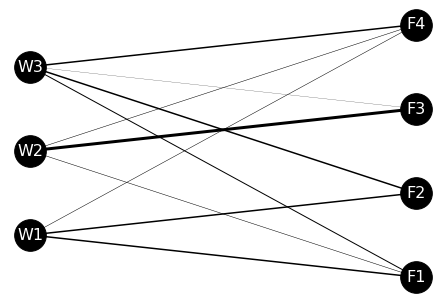

In [27]:
#그래프 다시 그리기
nx.draw(G, pos, with_labels=True,
               font_size = 16, node_size = 1000, node_color = 'k', font_color= 'w', width = sy) #width에 가중치 리스트 설정
plt.show()

In [28]:
G.edges

EdgeView([('W1', 'F1'), ('W1', 'F2'), ('W1', 'F3'), ('W1', 'F4'), ('W2', 'F1'), ('W2', 'F2'), ('W2', 'F3'), ('W2', 'F4'), ('W3', 'F1'), ('W3', 'F2'), ('W3', 'F3'), ('W3', 'F4')])

In [29]:
len(G.edges)

12

In [30]:
df_pos

,W1,W2,W3,F1,F2,F3,F4
0,0,0,0,4.0,4.0,4.0,4.0
1,1,2,3,0.5,1.5,2.5,3.5


In [31]:
#객체
G = nx.Graph()

#노드 설정(W 3개, F 4개)
for i in range(len(df_pos.columns)):
    G.add_node(df_pos.columns[i])
    
G.add_edge(df_pos.columns[0], df_pos.columns[1])
print(len(G.edges), G.edges)

1 [('W1', 'W2')]


In [32]:
num_pre = 0
if num_pre < len(G.edges):
    num_pre = len(G.edges)
    
print(num_pre, len(G.edges))

1 1


1
[0]
2
[0, 0]
3
[0, 0, 1.5]
4
[0, 0, 1.5, 1.5]
5
[0, 0, 1.5, 1.5, 0]
6
[0, 0, 1.5, 1.5, 0, 0.5]
7
[0, 0, 1.5, 1.5, 0, 0.5, 0]
8
[0, 0, 1.5, 1.5, 0, 0.5, 0, 0.5]
9
[0, 0, 1.5, 1.5, 0, 0.5, 0, 0.5, 0]
10
[0, 0, 1.5, 1.5, 0, 0.5, 0, 0.5, 0, 3.0]
11
[0, 0, 1.5, 1.5, 0, 0.5, 0, 0.5, 0, 3.0, 0.5]
12
[0, 0, 1.5, 1.5, 0, 0.5, 0, 0.5, 0, 3.0, 0.5, 1.0]
13
[0, 0, 1.5, 1.5, 0, 0.5, 0, 0.5, 0, 3.0, 0.5, 1.0, 1.5]
14
[0, 0, 1.5, 1.5, 0, 0.5, 0, 0.5, 0, 3.0, 0.5, 1.0, 1.5, 0.2]
15
[0, 0, 1.5, 1.5, 0, 0.5, 0, 0.5, 0, 3.0, 0.5, 1.0, 1.5, 0.2, 1.5]
16
[0, 0, 1.5, 1.5, 0, 0.5, 0, 0.5, 0, 3.0, 0.5, 1.0, 1.5, 0.2, 1.5, 0]
17
[0, 0, 1.5, 1.5, 0, 0.5, 0, 0.5, 0, 3.0, 0.5, 1.0, 1.5, 0.2, 1.5, 0, 0]
18
[0, 0, 1.5, 1.5, 0, 0.5, 0, 0.5, 0, 3.0, 0.5, 1.0, 1.5, 0.2, 1.5, 0, 0, 0]
19
[0, 0, 1.5, 1.5, 0, 0.5, 0, 0.5, 0, 3.0, 0.5, 1.0, 1.5, 0.2, 1.5, 0, 0, 0, 0]
20
[0, 0, 1.5, 1.5, 0, 0.5, 0, 0.5, 0, 3.0, 0.5, 1.0, 1.5, 0.2, 1.5, 0, 0, 0, 0, 0]
21
[0, 0, 1.5, 1.5, 0, 0.5, 0, 0.5, 0, 3.0, 0.5, 1.0, 1.5, 0.2, 1.5, 0,

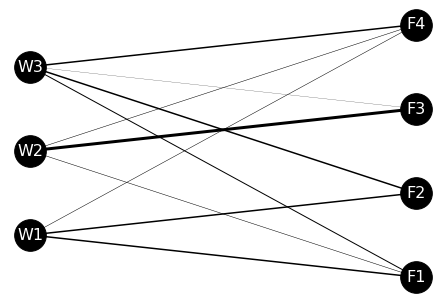

In [33]:
# 교재에서 한 방법 -> df_pos의 모든 컬럼값을 뽑되 자기 자신이 아닌 경우만 노드 연결(엣지 설정) & 가중치 추가 
## 내가 한 방법이 더 간단한거 같긴 하지만,, 교재처럼 해도 됨! 이 경우 엣지설정과 가중치 리스트를 한꺼번에 만드는 코드

#객체
G = nx.Graph()

#노드 설정(W 3개, F 4개)
for i in range(len(df_pos.columns)):
    G.add_node(df_pos.columns[i])

    
#----------------------------------------- 엣지와 가중치 리스트 설정을 한번에! 
num_pre = 0
edge_w = [] #가중치 리스트. for문을 통해 가중치(weight) 값을 하나하나 쌓을것 
size = 0.1

for i in range(len(df_pos.columns)):
    for j in range(len(df_pos.columns)):
        if i != j :
            #이 경우에만 엣지 설정 -> 자기자신에 대해서는 X, 다만 W끼리, F끼리도 엣지 설정할 수 있음 (가중치만 안 넣어주면 됨)
            G.add_edge(df_pos.columns[i], df_pos.columns[j])
            #엣지 가중치 추가
            if num_pre < len(G.edges): #num_pre의 기본값인 0보다 len(G.edges)가 크다면 (즉, 엣지가 하나 이상 만들어진 경우)
                num_pre = len(G.edges) #num_pre 값을 len(G.edges)로 바꿔줌
                weight = 0 #가중치 초기화 : W끼리/ F끼리의 엣지라면 0으로 넣게됨.
                
                ## 이제 weight를 추가해보자. (weight는 W와 F 간에만 존재)
                if (df_pos.columns[i] in df_tr.columns) and (df_pos.columns[j] in df_tr.index): #i에 해당하는 F 와 j에 해당하는 W값이 존재(True) 한다면
                    if df_tr[df_pos.columns[i]][df_pos.columns[j]]: #가중치값이 존재(True)한다면
                        weight = df_tr[df_pos.columns[i]][df_pos.columns[j]]*size #weight에 그 값을 넣기
                        
                elif (df_pos.columns[j] in df_tr.columns) and (df_pos.columns[i] in df_tr.index): #반대로, j에 해당하는 F와 i에 해당하는 W 값이 존재한다면
                    if df_tr[df_pos.columns[j]][df_pos.columns[i]]: #그리고 가중치값이 존재한다면
                        weight = df_tr[df_pos.columns[j]][df_pos.columns[i]]*size #weight에 그 값을 넣기 
                        
                #weight(가중치) 리스트화
                edge_w.append(weight)
                print(num_pre)
                print(edge_w)
#---------------------------------------------   
        
#좌표 설정
pos = {}
for i in range(len(df_pos.columns)):
    node = df_pos.columns[i]
    pos[node] = (df_pos[node][0],df_pos[node][1])
    
#그리기
nx.draw(G, pos, with_labels=True,
               font_size = 16, node_size = 1000, node_color = 'k', font_color= 'w', width = edge_w) #width에 가중치 리스트 설정)
plt.show()

위의 결과를 보면 num_pre는 가중치 리스트(edge_w)의 개수와 동일함을 알수있고,  
if문이 한번 실행될 때마다 edge_w에 가중치값이 차곡차곡 담긴다. W끼리의 가중치이거나 F끼리의 가중치이면 기본값인 0이 담기고,  
W와 F 간의 가중치이면 df_tr에 있는 가중치값이 담긴다.  
이렇게해서 총 21개의 가중치가 담기는데, 이는 7개의 가짓수에서 중복을 포함하지 않게 2개를 선택하는 경우 7C2 = 21 값과 동일하다.  

---
근데 나는 내가 한 방식이 더 쉬운 거 같음! 어차피 W끼리, F끼리는 가중치값이 0이므로 애초에 포함시키지 않는 것이다.  
즉, W와 F 이렇게 2개에서 하나씩 뽑히는 경우만 넣어서 중복 포함하지 않게 선택하므로 3C1 * 4C1 = 12 개가 나온다.

## Tech 58. 운송 비용 함수(목적 함수)를 작성하자
위에서 간단하게 운송 데이터를 갖고 창고와 공장 간 이동관계를 네트워크화했다.  
결과를 보면, 어느 창고에서 어느 공장으로 가든 골고루 경로가 있다는 것이다. 운송비용을 효율화하고 싶다면 경로가 특정 경로에만 집중되는 편이 좋을 것이다.   

---
이제는 최적화 문제를 풀어보자.  
최적화란, 목적함수(Objectivefucntion)을 정의하고, 제약식을 정의한다. 그 후 제약 조건 하에서 해당 목적 함수를 최대화 or 최소화할 수 있는 최적 조건을 찾는다. 그것이 바로 최적화이다.  
여기서는 우리의 목적이 무엇일까? 앞서도 이야기했듯 "운송 비용을 낮추기 위한 효율적인 운송 경로를 만드는 것" 이다.  

그러므로 `목적 함수 = 운송 비용 계산 함수`이며, 우리는 이 목적 함수를 최소화할 수 있는 최적조건을 찾으면 된다.

In [34]:
#운송 비용을 계산하는 함수 만들기
import pandas as pd

#데이터 불러오기
df_tr = pd.read_csv('6장/trans_route.csv', index_col = '공장') #창고- 공장 간 운송 경로
df_tc = pd.read_csv('6장/trans_cost.csv', index_col = '공장') #창고-공장 간 운송하는 데 드는 비용

display(df_tr, df_tc)

,F1,F2,F3,F4
공장,,,,
W1,15,15,0,5
W2,5,0,30,5
W3,10,15,2,15


,F1,F2,F3,F4
공장,,,,
W1,10,10,11,27
W2,18,21,12,14
W3,15,12,14,12


In [35]:
#운송 비용 함수
def trans_cost(df_tr, df_tc):
    cost = 0
    for i in range(len(df_tc.index)): #i : W(창고)
        for j in range(len(df_tr.columns)): #j : F(공장)
            cost += df_tr.iloc[i][j]*df_tc.iloc[i][j] #운송 비용: i-> j 로 갈 때 몇 번 갔는지 * 드는 비용 을 모두 더함 
    return cost

In [36]:
#이 예제에서 총 운송비용은 얼마가 나오는지 함수를 적용해보면
trans_cost(df_tr, df_tc)

1493

## Tech 59. 제약 조건 만들기
다음으로는 목적함수에 적용할 제약식을 만든다. 어떤 제약조건이 있을까?  
- 창고(W): 공급 가능한 부품 수가 제한됨 -> `supply` (이 정도까지만 공급 가능. 더 많이 만들 수 없음)
- 공장(F): 채워야 할 최소한의 제품 제조량이 있음 -> `demand` (최소한 이 수요량이 필요함. 더 적으면 안됨)

In [37]:
import pandas as pd

#필요한 데이터
df_tr = pd.read_csv('6장/trans_route.csv', index_col = '공장')
df_demand = pd.read_csv('6장/demand.csv')
df_supply = pd.read_csv('6장/supply.csv')

display(df_tr, df_demand, df_supply)

,F1,F2,F3,F4
공장,,,,
W1,15,15,0,5
W2,5,0,30,5
W3,10,15,2,15


,F1,F2,F3,F4
0,28,29,31,25


,W1,W2,W3
0,35,41,42


In [38]:
#수요측 제약조건 
for i in range(len(df_demand.columns)):
    temp_sum = sum(df_tr[df_demand.columns[i]]) #해당 공장(F)에서 필요한 수요의 합. 실제로 이 공장에서 W들 토탈 몇 번 갔냐?
    
    #그렇다면 temp_sum(실제 수요) >= demand(최소 수요) 여야겠지? 그 반대면 수요량을 만족시키고 있지 않을 것
    if temp_sum >= df_demand.iloc[0][i]:
        print('수요량 만족')
    else: print('수요량 만족X. 운송경로 재계산 필요')
    
    #정보 출력
    print("공장 " + str(df_demand.columns[i]) + " 운송량: " + str(temp_sum) + " (수요량 :" + str(df_demand.iloc[0][i]) + ")" )
    print(" ")

수요량 만족
공장 F1 운송량: 30 (수요량 :28)
 
수요량 만족
공장 F2 운송량: 30 (수요량 :29)
 
수요량 만족
공장 F3 운송량: 32 (수요량 :31)
 
수요량 만족
공장 F4 운송량: 25 (수요량 :25)
 


In [39]:
#공급측 제약조건
for i in range(len(df_supply.columns)):
    temp_sum = sum(df_tr.loc[df_supply.columns[i]]) #반대로 해당 창고(W)에서 공급한 양의 합. 실제로 이 창고의 공급은 몇번이냐?
    
    #그렇다면 temp_sum(실제 공급) <= supply(최대 공급) 이어야겠지? 실제로는 최대로 공급할 수 있는 양보다 더 적거나 같을 것
    if temp_sum <= df_supply.iloc[0][i]:
        print('공급한계 범위내')
    else: print('공급한계 초과. 운송경로 재계산 필요')
        
    #정보 출력
    print("창고 " + str(df_supply.columns[i]) + " 운송량: " + str(temp_sum) + " (공급량 :" + str(df_supply.iloc[0][i]) + ")" )
    print(" ")

공급한계 범위내
창고 W1 운송량: 35 (공급량 :35)
 
공급한계 범위내
창고 W2 운송량: 40 (공급량 :41)
 
공급한계 범위내
창고 W3 운송량: 42 (공급량 :42)
 


## Tech 60. 운송 경로를 변경해서, 운송 비용 함수(목적함수)의 변화를 확인하자
주어진 데이터 df_tr 에 대해서는 수요와 공급량을 모두 만족시키는 것으로 나타났다.  
비용을 줄이기 위해, W1 -> F4로의 운송을 줄이고, 대신 W2 -> F4 운송을 더 늘린 새로운 운송경로 데이터 `trans_route_new` 를 불러와, 위에 만든 함수에 적용하고 제약조건 하에서 최소의 비용을 냈는지를 알아보자.

In [40]:
import pandas as pd
import numpy as np

#데이터 불러오기
df_tr_new = pd.read_csv('6장/trans_route_new.csv', index_col = '공장')
df_tr_new

,F1,F2,F3,F4
공장,,,,
W1,15,15,0,0
W2,5,0,30,10
W3,10,15,2,15


In [41]:
#운송 비용 계산 -> 아까보다 줄어듦
print('기존:', trans_cost(df_tr, df_tc), '변경:', trans_cost(df_tr_new, df_tc))

기존: 1493 변경: 1428


In [42]:
flag = np.zeros(len(df_demand.columns))
flag

array([0., 0., 0., 0.])

In [43]:
flag[0]

0.0

In [44]:
flag.iloc[0,0]

AttributeError: 'numpy.ndarray' object has no attribute 'iloc'

In [45]:
#제약조건 함수화 -> 앞서 만든 if문에서, 수요(or 공급)을 만족하면 1, 아니면 0을 출력하도록 하는 flag를 만든다.
## 먼저 0으로 초기화시키고, 만족하는 경우엔 1을 넣어주기 

## 공장(F)의 수요
def c_demand(df_tr, df_demand):
    
    #초기화
    flag = np.zeros(len(df_demand.columns))
    
    #계산
    for i in range(len(df_demand.columns)):
        temp_sum = sum(df_tr[df_demand.columns[i]])
        if temp_sum >= df_demand.iloc[0][i]:
            flag[i] = 1
    
    return flag

## 창고(W)의 공급
def c_supply(df_tr, df_supply):
    
    #초기화
    flag = np.zeros(len(df_supply.columns))
    
    #계산
    for i in range(len(df_supply.columns)):
        temp_sum = sum(df_tr.loc[df_supply.columns[i]])
        if temp_sum <= df_supply.iloc[0][i]:
            flag[i] = 1
            
    return flag

In [46]:
#수요 계산 결과 -> 모두 필요한 수요 이상을 만족
c_demand(df_tr_new, df_demand)

array([1., 1., 1., 1.])

In [47]:
#공급 계산 결과 -> 최대 공급할수 있는 것보다 많은 게 하나 있음
c_supply(df_tr_new, df_supply)

array([1., 0., 1.])